# Email Classifier

## Bag of Words Model

In [638]:
import os
import nltk
from nltk.stem import PorterStemmer
import re
import string
import codecs
import numpy as np
import sys
from matplotlib import pyplot as plt

In [583]:
# Unzip the raw data zip file
# Uncomment the following line and run once if the zip file has not been unzipped

# ! tar -xf email_data.tar.gz

In [584]:
# Update the filepath depending on where the email data directory is located. For now, I placed this notebook and the
# unzipped data file in the current working directory.

path_to_all_emails = '/Users/crystalshin/Documents/GitHub/COMS4771/enron1'
path_to_ham = path_to_all_emails + '/ham'
path_to_spam = path_to_all_emails + '/spam'

In [585]:
# Empty dictionary to store all unique words
word_bag = {}
bag_idx = 1

# Initialize word stemmer
ps = PorterStemmer()

# list of filenames in ham & spam
filenames_ham = sorted(os.listdir(path_to_ham))
filenames_spam = sorted(os.listdir(path_to_spam))
all_filenames = filenames_ham + filenames_spam

for file in filenames_ham:
    text = open(path_to_ham+"/"+file, "r", encoding='latin1')
    data = text.read()
    text.close()
    data = re.sub('[,.;:@#?!&$-1234567890%/\'\"\(\)\`|+]+', '', data)
    data = re.sub('subject','',data)
    data = re.sub('cc','',data)
    tokenized = nltk.word_tokenize(data)
    stemmed = []
    for word in tokenized:
        stemmed.append(ps.stem(word))
    # add dictionary entries
    for stem in stemmed:
        if stem not in word_bag:
            word_bag[stem] = bag_idx
            bag_idx += 1

for file in filenames_spam:
    text = open(path_to_spam+"/"+file, "r", encoding='latin1')
    data = text.read()
    text.close()
    data = re.sub('[,.;:@#?!&$-1234567890%/\'\"\(\)\`|+]+', '', data)
    data = re.sub('subject','',data)
    data = re.sub('cc','',data)
    tokenized = nltk.word_tokenize(data)
    stemmed = []
    for word in tokenized:
        stemmed.append(ps.stem(word))
    # add dictionary entries
    for stem in stemmed:
        if stem not in word_bag:
            word_bag[stem] = bag_idx
            bag_idx += 1
            
print("Bag of words:", len(word_bag))

Bag of words: 38061


In [587]:
import operator as op

vector = []

for file in filenames_ham:
    text = open(path_to_ham+"/"+file, "r", encoding='latin1')
    data = text.read()
    text.close()
    data = re.sub('[,.;:@#?!&$-1234567890%/\'\"\(\)\`|+]+', '', data)
    data = re.sub('subject','',data)
    data = re.sub('cc','',data)
    tokenized = nltk.word_tokenize(data)
    stemmed = []
    for word in tokenized:
        stemmed.append(ps.stem(word))
    # Count each word
    count = []
    for key in word_bag:
        count.append(op.countOf(stemmed, key))
    vector.append((count, 0))
    
for file in filenames_spam:
    text = open(path_to_spam+"/"+file, "r", encoding='latin1')
    data = text.read()
    text.close()
    data = re.sub('[,.;:@#?!&$-1234567890%/\'\"\(\)\`|+]+', '', data)
    data = re.sub('subject','',data)
    data = re.sub('cc','',data)
    tokenized = nltk.word_tokenize(data)
    stemmed = []
    for word in tokenized:
        stemmed.append(ps.stem(word))
    # Count each word
    count = []
    for key in word_bag:
        count.append(op.countOf(stemmed, key))
    vector.append((count, 1))
    

## Train Test Split

In [588]:
# split helper function
from numpy import random

def train_test_split(word_vector, train_percent):
    vector_length = len(word_vector)
    split_index = round(vector_length * train_percent / 100)
    random.shuffle(word_vector)
    train = word_vector[:split_index]
    test = word_vector[split_index:]
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    for tupl in train:
        x_train.append(tupl[0])
        y_train.append(tupl[1])
    for tupl in test:
        x_test.append(tupl[0])
        y_test.append(tupl[1])
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)


In [848]:
# split data
x_train, y_train, x_test, y_test = train_test_split(vector, 70)

## Naive-Bayes

In [800]:
def fit_naive_bayes(x_train, y_train):
    # Calculate the class priors: 
    ham_prior = sum(y==0 for y in y_train)/len(y_train)
    spam_prior = sum(y==1 for y in y_train)/len(y_train)

    # Separate hams and spams:
    ham_occurances = []
    spam_occurances = []
    for idx, y in enumerate(y_train):
        if y == 0:
            ham_occurances.append(x_train[idx])
        else:
            spam_occurances.append(x_train[idx])
    ham_occurances = np.array(ham_occurances)
    spam_occurances = np.array(spam_occurances)
    
    # Sum up the wordcounts to find p x given y
    ham_wordsum = ham_occurances.sum(axis=0)
    
    # Calculate the conditionals by dividing the total number of each word by the total number of words in ham or spam
    ham_conditional = ham_wordsum / ham_occurances.sum()

    spam_wordsum = spam_occurances.sum(axis=0)
    spam_conditional = spam_wordsum / spam_occurances.sum()
    
    return ham_prior, spam_prior, ham_conditional, spam_conditional

In [801]:
def predict_naive_bayes(ham_prior, spam_prior, ham_conditional, spam_conditional, x_test, y_test):
    # Calculate the posteriors:
    ham_posterior = []
    spam_posterior = []

    for row in x_test:
        ham_posterior.append(np.prod(np.power(ham_conditional, row))*ham_prior)
        spam_posterior.append(np.prod(np.power(spam_conditional, row))*spam_prior)

    y_hat = []
    for i in range(len(y_test)):
        if ham_posterior[i] >= spam_posterior[i]:
            y_hat.append(0)
        else:
            y_hat.append(1)
    accuracy = np.sum(y_hat==y_test)/len(y_test)
    
    return accuracy

In [796]:
ham_prior, spam_prior, ham_conditional, spam_conditional = fit_naive_bayes(x_train, y_train)

In [797]:
accuracy = predict_naive_bayes(ham_prior, spam_prior, ham_conditional, spam_conditional, x_test, y_test)
accuracy

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1
 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0]


0.720515574650913

In [ ]:
nb_accuracy = []
for split in range(10,100,10):
    cum_acc = 0
    for i in range(5):
        x_train, y_train, x_test, y_test = train_test_split(vector, split)
        ham_prior, spam_prior, ham_conditional, spam_conditional = fit_naive_bayes(x_train, y_train)
        cum_acc += predict_naive_bayes(ham_prior, spam_prior, ham_conditional, spam_conditional, x_test, y_test)
    nb_accuracy.append(cum_acc/5)

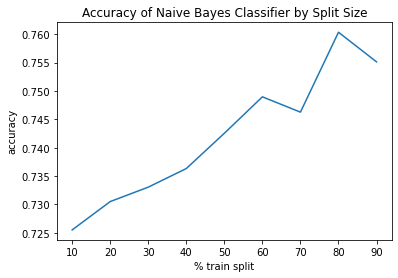

[0.725499462943072, 0.7304978250362494, 0.7330386740331492, 0.7363196906219788, 0.7425367362722352, 0.748960850652489, 0.7462628865979382, 0.7603481624758222, 0.7551257253384913]


In [814]:
plt.plot(range(10,100,10), nb_accuracy)
plt.xlabel('% train split')
plt.ylabel('accuracy')
plt.title('Accuracy of Naive Bayes Classifier by Split Size')
plt.show()
print(nb_accuracy)

## KNN

In [816]:
# Calculating distances helper function:
import numpy.linalg as l

def calculate_distance(train, test, normtype):
    return l.norm(test-train, normtype)

### 1-NN

In [817]:
def oneNN(x_train, y_train, x_test, y_test, normtype):
    y_hat = []
    for i in range(len(x_test)): # for each test email
        # calculate the distance from a test email to all the training emails and take the minimum
        distances = []
        for j in range(len(x_train)): # for each training email
            distance = calculate_distance(x_train[j], x_test[i], normtype)
            distances.append(distance)
        distances = np.array(distances)
        min_idx = np.argmin(distances)
        y_hat.append(y_train[min_idx])
        
    accuracy = np.sum(y_hat==y_test)/len(y_test)
    return accuracy

In [850]:
accuracy = oneNN(x_train, y_train, x_test, y_test, 2)
print(accuracy)

0.916881443298969


### kNN

In [747]:
from collections import Counter

def kNN(x_train, y_train, x_test, y_test, normtype, k):
    y_hat = []
    for i in range(len(x_test)): # for each test email
        # calculate the distance from a test email to all the training emails and take the minimum
        distances = []
        for j in range(len(x_train)): # for each training email
            distance = calculate_distance(x_train[j], x_test[i], normtype)
            distances.append(distance)
        distances = np.array(distances)
        min_idx = (np.argpartition(distances, k))[:k]
        neighbor_labels = []
        for idx in min_idx:
            neighbor_labels.append(y_train[idx])
        counter = Counter(neighbor_labels)
        majority_vote = counter.most_common(1)[0][0]
        y_hat.append(majority_vote)
        
    accuracy = np.sum(y_hat==y_test)/len(y_test)
    return accuracy

In [ ]:
accuracy = kNN(x_train, y_train, x_test, y_test, 2, 3)
print(accuracy)

In [852]:
# results for graphing all types of knn
splits = [10,30,50,]
onennlone = [0.7617615467,0.8361878453,0.845320959]
onennltwo = [0.8216970999,0.8809392265,0.9025522042]
onennlinf = [0.7499462943,0.7839779006,0.8526682135]
threennlone = [0.7939849624,0.829558011,0.788863109]
threennltwo = [0.838453276,0.8754143646,0.8832173241]
threennlinf = [0.7737916219,0.8099447514,0.8360402166]
fivennlone = [0.7974221267,0.811878453,0.7556071152]
fivennltwo = [0.8240601504,0.8770718232,0.8700696056]
fivennlinf = [0.774650913,0.8080110497,0.8321732405]

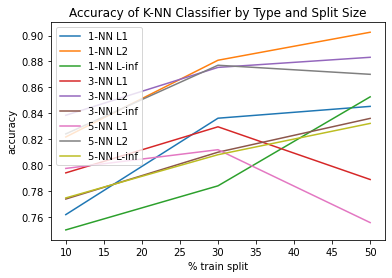

In [859]:
# Knn graph
plt.plot(splits, onennlone, label = "1-NN L1")
plt.plot(splits, onennltwo, label = "1-NN L2")
plt.plot(splits, onennlinf, label = "1-NN L-inf")
plt.plot(splits, threennlone, label = "3-NN L1")
plt.plot(splits, threennltwo, label = "3-NN L2")
plt.plot(splits, threennlinf, label = "3-NN L-inf")
plt.plot(splits, fivennlone, label = "5-NN L1")
plt.plot(splits, fivennltwo, label = "5-NN L2")
plt.plot(splits, fivennlinf, label = "5-NN L-inf")
plt.xlabel('% train split')
plt.ylabel('accuracy')
plt.title('Accuracy of K-NN Classifier by Type and Split Size')
plt.legend(loc="upper left")
plt.show()

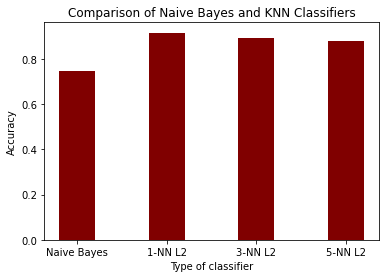

In [854]:
# Compare knn and naive bayes
nb_seventy = 0.7462628865979382

naive_bayes_knn = {'Naive Bayes':0.7462628865979382, '1-NN L2':0.916881443298969, '3-NN L2':0.8920301182,
        '5-NN L2':0.8811003912}
classifier = list(naive_bayes_knn.keys())
values = list(naive_bayes_knn.values())

plt.bar(classifier, values, color ='maroon', width = 0.4)
plt.xlabel("Type of classifier")
plt.ylabel("Accuracy")
plt.title("Comparison of Naive Bayes and KNN Classifiers")
plt.show()